# Deep Neural Network for Image Classification: Application

When you finish this, you will have finished the last programming assignment of Week 4, and also the last programming assignment of this course! 

You will use use the functions you'd implemented in the previous assignment to build a deep network, and apply it to cat vs non-cat classification. Hopefully, you will see an improvement in accuracy relative to your previous logistic regression implementation.  

**After this assignment you will be able to:**
- Build and apply a deep neural network to supervised learning. 

Let's get started!

## 1 - Packages

In [23]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import h5py
import time

from PIL import Image
from scipy import ndimage

%matplotlib inline

## 2 - Dataset

In [27]:
train_data = h5py.File("train_catvnoncat.h5","r")
train_data_x = np.array(train_data["train_set_x"][:])
train_data_y = np.array(train_data["train_set_y"][:])

test_data = h5py.File("test_catvnoncat.h5","r")
test_data_x = np.array(test_data["test_set_x"][:])
test_data_y = np.array(test_data["test_set_y"][:])

classes = np.array(test_data["list_classes"][:])

In [28]:
train_y = train_data_y.reshape(1,train_data_y.shape[0])
test_y = test_data_y.reshape(1,test_data_y.shape[0])

### 2.1 Display the data

y label is 0 It is a non-cat


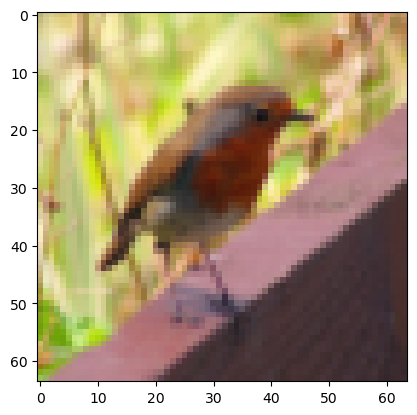

In [4]:
index = 10

plt.imshow(train_data_x[index,:])

print("y label is "+str(train_y[0,index])+" It is a "+classes[int(train_y[:,index])].decode("utf-8") )

In [29]:
m_train = train_data_x.shape[0]
m_test = test_data_x.shape[0]
num_px = train_data_x.shape[1]

print ("Number of training examples: m_train = " + str(m_train))
print ("Number of testing examples: m_test = " + str(m_test))
print ("Height/Width of each image: num_px = " + str(num_px))
print()
print("Train x shape: ", train_data_x.shape)
print("Train y shape: ", train_y.shape)
print("Test x shape: ", test_data_x.shape)
print("Test y shape: ", test_y.shape)
print("Classes in the data: ",np.unique(classes))

Number of training examples: m_train = 209
Number of testing examples: m_test = 50
Height/Width of each image: num_px = 64

Train x shape:  (209, 64, 64, 3)
Train y shape:  (1, 209)
Test x shape:  (50, 64, 64, 3)
Test y shape:  (1, 50)
Classes in the data:  [b'cat' b'non-cat']


### 2.2 Flatten the data and Standardize the data
Reshape images of shape (num_px, num_px, 3) in a numpy-array of shape (num_px * num_px * 3, 1). After this, our training (and test) dataset is a numpy-array where each column represents a flattened image. There should be m_train (respectively m_test) columns.

**Exercise**: Reshape the training and test data sets so that images of size (num_px, num_px, 3) are flattened into single vectors of shape (num_px * num_px * 3, 1).
 
A trick when you want to flatten a matrix X of shape (a,b,c,d) to a matrix X_flatten of shape (bcd, a) is to use:

X_flatten = X.reshape(X.shape[0], -1).T      # X.T is the transpose of X


<img src="images/imvectorkiank.png" style="width:450px;height:300px;">

In [30]:
train_set_x_flatten = train_data_x.reshape(train_data_x.shape[0],-1).T
test_set_x_flatten = test_data_x.reshape(test_data_x.shape[0],-1).T

print("Train x flattened shape: ", train_set_x_flatten.shape)
print("Test x flattened shape: ", test_set_x_flatten.shape)

# standardize the data so the values are betwee 0 to 1

train_x = train_set_x_flatten/255
test_x = test_set_x_flatten/255

print ("train_x's shape: " + str(train_x.shape))
print ("test_x's shape: " + str(test_x.shape))

Train x flattened shape:  (12288, 209)
Test x flattened shape:  (12288, 50)
train_x's shape: (12288, 209)
test_x's shape: (12288, 50)


## 3 - Architecture of your model

Now that you are familiar with the dataset, it is time to build a deep neural network to distinguish cat images from non-cat images.

You will build two different models:
- A 2-layer neural network
- An L-layer deep neural network

You will then compare the performance of these models, and also try out different values for $L$. 

Let's look at the two architectures.

### 3.1 - 2-layer neural network

<img src="images/2layerNN_kiank.png" style="width:650px;height:400px;">
<caption><center> <u>Figure 2</u>: 2-layer neural network. <br> The model can be summarized as: ***INPUT -> LINEAR -> RELU -> LINEAR -> SIGMOID -> OUTPUT***. </center></caption>

<u>Detailed Architecture of figure 2</u>:
- The input is a (64,64,3) image which is flattened to a vector of size $(12288,1)$. 
- The corresponding vector: $[x_0,x_1,...,x_{12287}]^T$ is then multiplied by the weight matrix $W^{[1]}$ of size $(n^{[1]}, 12288)$.
- You then add a bias term and take its relu to get the following vector: $[a_0^{[1]}, a_1^{[1]},..., a_{n^{[1]}-1}^{[1]}]^T$.
- You then repeat the same process.
- You multiply the resulting vector by $W^{[2]}$ and add your intercept (bias). 
- Finally, you take the sigmoid of the result. If it is greater than 0.5, you classify it to be a cat.

### 3.2 - L-layer deep neural network

It is hard to represent an L-layer deep neural network with the above representation. However, here is a simplified network representation:

<img src="images/LlayerNN_kiank.png" style="width:650px;height:400px;">
<caption><center> <u>Figure 3</u>: L-layer neural network. <br> The model can be summarized as: ***[LINEAR -> RELU] $\times$ (L-1) -> LINEAR -> SIGMOID***</center></caption>

<u>Detailed Architecture of figure 3</u>:
- The input is a (64,64,3) image which is flattened to a vector of size (12288,1).
- The corresponding vector: $[x_0,x_1,...,x_{12287}]^T$ is then multiplied by the weight matrix $W^{[1]}$ and then you add the intercept $b^{[1]}$. The result is called the linear unit.
- Next, you take the relu of the linear unit. This process could be repeated several times for each $(W^{[l]}, b^{[l]})$ depending on the model architecture.
- Finally, you take the sigmoid of the final linear unit. If it is greater than 0.5, you classify it to be a cat.

### 3.3 - General methodology

As usual you will follow the Deep Learning methodology to build the model:
    1. Initialize parameters / Define hyperparameters
    2. Loop for num_iterations:
        a. Forward propagation
        b. Compute cost function
        c. Backward propagation
        d. Update parameters (using parameters, and grads from backprop) 
    4. Use trained parameters to predict labels

Let's now implement those two models!

### 3.4 Helper functions

In [31]:
def sigmoid(z):
    s = 1/(1+np.exp(-z))
    return s,z

def relu(z):
    r = np.maximum(0,z)
    return r,z

def sigmoid_backward(dA,activation_cache): #dgZ = da/dz
    z = activation_cache
    a = 1/(1+np.exp(-z))
    dgZ = np.multiply(a,1-a)
    dZ = dA * dgZ
    return dZ

def relu_backward(dA, activation_cache): #dgZ = da/dz
    Z = activation_cache
    dZ = np.array(dA, copy=True)
    # When z <= 0, you should set dz to 0 as well. 
    dZ[Z <= 0] = 0
    return dZ

## 4 - Two-layer neural network

**Question**:  Use the helper functions you have implemented in the previous assignment to build a 2-layer neural network with the following structure: *LINEAR -> RELU -> LINEAR -> SIGMOID*. The functions you may need and their inputs are:
```python
def initialize_parameters(n_x, n_h, n_y):
    ...
    return parameters    

def linear_activation_forward(A_prev, W, b, activation):
    ...
    return A, cache   

def compute_cost(AL, Y):
    ...
    return cost   

def linear_activation_backward(dA, cache, activation):
    ...
    return dA_prev, dW, db   

def update_parameters(parameters, grads, learning_rate):
    ...
    return parameters
```

### 4.1 Initialize parameters

In [8]:
def initialize_parameters(n_x, n_h, n_y):
    """
    Argument:
    n_x -- size of the input layer
    n_h -- size of the hidden layer
    n_y -- size of the output layer
    
    Returns:
    parameters -- python dictionary containing your parameters:
                    W1 -- weight matrix of shape (n_h, n_x)
                    b1 -- bias vector of shape (n_h, 1)
                    W2 -- weight matrix of shape (n_y, n_h)
                    b2 -- bias vector of shape (n_y, 1)
    """
    np.random.seed(1)
    
    W1 = np.random.randn(n_h,n_x)*0.01
    b1 = np.zeros((n_h,1))
    W2 = np.random.randn(n_y,n_h)*0.01
    b2 = np.zeros((n_y,1))
    
    parameters = { 
                "W1":W1,
                "b1":b1,
                "W2":W2,
                "b2":b2
                 }
    
    return parameters

### 4.2 Linear activation forward

In [32]:


def linear_forward(A, W, b):
    """
    FOR A SINGLE LAYER
    
    Implement the linear part of a layer's forward propagation.

    Arguments:
    A -- activations from previous layer (or input data): (size of previous layer, number of examples)
    W -- weights matrix: numpy array of shape (size of current layer, size of previous layer)
    b -- bias vector, numpy array of shape (size of the current layer, 1)

    Returns:
    Z -- the input of the activation function, also called pre-activation parameter 
    cache -- list containing "A", "W" and "b" ; stored for computing the backward pass efficiently
    """
    
    Z = np.dot(W,A) + b
    cache = (A,W,b)
    
    assert(Z.shape == (W.shape[0], A.shape[1]))
    
    return Z, cache


def linear_activation_forward(A_prev, W, b, activation):
    """
    Implement the forward propagation for the LINEAR->ACTIVATION layer

    Arguments:
    A_prev -- activations from previous layer (or input data): (size of previous layer, number of examples)
    W -- weights matrix: numpy array of shape (size of current layer, size of previous layer)
    b -- bias vector, numpy array of shape (size of the current layer, 1)
    activation -- the activation to be used in this layer, stored as a text string: "sigmoid" or "relu"

    Returns:
    A -- the output of the activation function, also called the post-activation value 
    cache -- a python dictionary containing "linear_cache" and "activation_cache";
             stored for computing the backward pass efficiently
        
        linear cache : A_prev, W, b
        activation cache: Z
             
    """
    
    if activation == "sigmoid":
        Z,linear_cache = linear_forward(A_prev,W,b)
        A,activation_cache = sigmoid(Z)
        
    elif activation == "relu":
        Z,linear_cache = linear_forward(A_prev,W,b)
        A,activation_cache = relu(Z)
    
    assert (A.shape == (W.shape[0], A_prev.shape[1]))
    cache = (linear_cache,activation_cache)
        
    return A,cache

### 4.3 Compute cost

In [33]:


def compute_cost(AL, Y):
    """
    Implement the cost function for logistic regression.

    Arguments:
    AL -- probability vector corresponding to your label predictions, shape (1, number of examples)
    Y -- true "label" vector (for example: containing 0 if non-cat, 1 if cat), shape (1, number of examples)

    Returns:
    cost -- cross-entropy cost
    """
    
    m = Y.shape[1]
    
    log_probs = np.multiply(Y, np.log(AL)) + np.multiply(1-Y, np.log(1-AL))
    cost = - np.sum(log_probs)/m
    
    cost = np.squeeze(cost) #to make sure the cost is of dimension we need - turns [[17]] to 17
    
    assert(cost.shape == ())
    
    return cost

### 4.4 Linear activation backward

In [34]:
def linear_backward(dZ, cache):
    """
    FOR A SINGLE LAYER
    
    Implement the linear portion of backward propagation for a single layer (layer l)

    Arguments:
    dZ -- Gradient of the cost with respect to the linear output (of current layer l)
    cache -- tuple of values (A_prev, W, b) coming from the forward propagation in the current layer

    Returns:
    dA_prev -- Gradient of the cost with respect to the activation (of the previous layer l-1), same shape as A_prev
    dW -- Gradient of the cost with respect to W (current layer l), same shape as W
    db -- Gradient of the cost with respect to b (current layer l), same shape as b
    """
    
    A_prev = cache[0]
    W = cache[1]
    b = cache[2]
    
    m = A_prev.shape[1]
    
    dW = (1/m) * np.dot(dZ,A_prev.T)
    db = (1/m) * np.sum(dZ, axis=1, keepdims= True)
    
    dA_prev = np.dot(W.T,dZ)
    
    assert (dW.shape==W.shape)
    assert (db.shape==b.shape)
    assert (dA_prev.shape==A_prev.shape)
    
    return dA_prev, dW, db

def linear_activation_backward(dA, cache, activation):
    """
    Implement the backward propagation for the LINEAR->ACTIVATION layer.
    
    Arguments:
    dA -- post-activation gradient for current layer l 
    cache -- tuple of values (linear_cache, activation_cache) we store for computing backward propagation efficiently
    activation -- the activation to be used in this layer, stored as a text string: "sigmoid" or "relu"
        linear cache: A_prev, w, b
        activation cache: Z
    
    Returns:
    dA_prev -- Gradient of the cost with respect to the activation (of the previous layer l-1), same shape as A_prev
    dW -- Gradient of the cost with respect to W (current layer l), same shape as W
    db -- Gradient of the cost with respect to b (current layer l), same shape as b
    """
    
    linear_cache, activation_cache = cache
    
    
    if activation == "sigmoid":
        dZ = sigmoid_backward(dA, activation_cache)
    
    elif activation == "relu":
        dZ = relu_backward(dA, activation_cache)
        
    dA_prev, dW, db = linear_backward(dZ, linear_cache)
    
    return dA_prev, dW, db

### 4.5 Update parameters

In [35]:

def update_parameters(parameters, grads, learning_rate):
    """
    Update parameters using gradient descent
    
    Arguments:
    parameters -- python dictionary containing your parameters 
    grads -- python dictionary containing your gradients, output of L_model_backward
    
    Returns:
    parameters -- python dictionary containing your updated parameters 
                  parameters["W" + str(l)] = ... 
                  parameters["b" + str(l)] = ...
    """    
    L = len(parameters) // 2 # number of layers in the neural network
    # Update rule for each parameter. Use a for loop.
    for l in range(L):
        parameters["W" + str(l+1)] = parameters["W" + str(l+1)] - learning_rate * grads["dW" + str(l+1)]
        parameters["b" + str(l+1)] = parameters["b" + str(l+1)] - learning_rate * grads["db" + str(l+1)]
    return parameters

### 4.6 Two-layer neural network

In [13]:
n_x = 12288
n_h = 7 #hidden units in layer 1
n_y = 1

In [6]:
def two_layer_NN(X,Y,layers_dims,learning_rate=0.0075, num_iterations = 3000, print_cost=False):
    
    np.random.seed(1)
    grads = {}
    costs = []
    (n_x,n_h,n_y) = layers_dims
    
    parameters = initialize_parameters(n_x,n_h,n_y)
    
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    
    for i in range(0,num_iterations):
        
        #FORWARD PROPAGATION
    
        #for layer 1
        A0 = X
        A1,cache1 = linear_activation_forward(A0, W1, b1, activation="relu")
        #for output layer
        A2,cache2 = linear_activation_forward(A1, W2, b2, activation="sigmoid")

        cost = compute_cost(A2,Y)

        #BACKWARD PROPAGATION

        #for output layer
        dA2 = - (np.divide(Y,A2) - np.divide(1-Y,1-A2))
        dA1, dW2, db2 = linear_activation_backward(dA2, cache2, activation="sigmoid")
        #for layer 1
        dA0, dW1, db1 = linear_activation_backward(dA1, cache1, activation="relu")

        grads["dW1"] = dW1
        grads["db1"] = db1
        grads["dW2"] = dW2
        grads["db2"] = db2

        parameters = update_parameters(parameters, grads, learning_rate)

        W1 = parameters["W1"]
        b1 = parameters["b1"]
        W2 = parameters["W2"]
        b2 = parameters["b2"]

        # Print the cost every 100 training example
        if print_cost and i % 100 == 0:
            print("Cost after iteration {}: {}".format(i, np.squeeze(cost)))
        if print_cost and i % 100 == 0:
            costs.append(cost)
       
    # plot the cost

    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per tens)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return parameters

Cost after iteration 0: 0.6930497356599891
Cost after iteration 100: 0.6464320953428849
Cost after iteration 200: 0.6325140647912677
Cost after iteration 300: 0.6015024920354665
Cost after iteration 400: 0.5601966311605748
Cost after iteration 500: 0.515830477276473
Cost after iteration 600: 0.4754901313943326
Cost after iteration 700: 0.4339163151225749
Cost after iteration 800: 0.4007977536203889
Cost after iteration 900: 0.35807050113237976
Cost after iteration 1000: 0.3394281538366414
Cost after iteration 1100: 0.3052753636196265
Cost after iteration 1200: 0.27491377282130175
Cost after iteration 1300: 0.24681768210614854
Cost after iteration 1400: 0.19850735037466088
Cost after iteration 1500: 0.17448318112556654
Cost after iteration 1600: 0.1708076297809581
Cost after iteration 1700: 0.11306524562164741
Cost after iteration 1800: 0.09629426845937146
Cost after iteration 1900: 0.0834261795972686
Cost after iteration 2000: 0.07439078704319078
Cost after iteration 2100: 0.0663074813

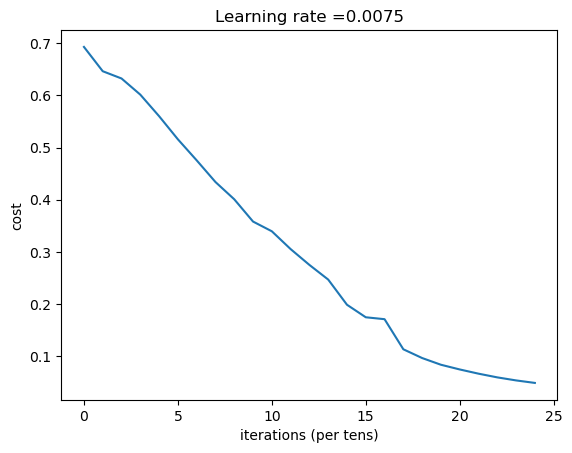

In [15]:
parameters = two_layer_NN(train_x, train_y, layers_dims = (n_x, n_h, n_y), num_iterations = 2500, print_cost=True)


In [16]:
def predict(test_x, test_y, parameters):
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    
    m = test_y.shape[1]
    
    #Layer 1
    A0 = test_x
    A1,cache1 = linear_activation_forward(A0, W1, b1, activation="relu")
    #Output layer
    A2,cache2 = linear_activation_forward(A1, W2, b2, activation="sigmoid")

    y_pred = (A2 > 0.5).astype(int)
    
    accuracy = (np.dot(test_y[0],y_pred[0]) + np.dot(1-test_y[0],1-y_pred[0]))/m
    print("Accuracy: ", accuracy)
    
    return accuracy

In [17]:
predictions_test = predict(test_x, test_y, parameters)

Accuracy:  0.72


## 5 - L-layer Neural Network

**Question**: Use the helper functions you have implemented previously to build an $L$-layer neural network with the following structure: *[LINEAR -> RELU]$\times$(L-1) -> LINEAR -> SIGMOID*. The functions you may need and their inputs are:
```python
def initialize_parameters_deep(layer_dims):
    ...
    return parameters 
def L_model_forward(X, parameters):
    ...
    return AL, caches
def compute_cost(AL, Y):
    ...
    return cost
def L_model_backward(AL, Y, caches):
    ...
    return grads
def update_parameters(parameters, grads, learning_rate):
    ...
    return parameters
```

### 5.1 Initialize parameters

In [43]:


def initialize_parameters_deep(layer_dims):
    """
    Arguments:
    layer_dims -- python array (list) containing the dimensions of each layer in our network
    [nx,n1,n2,n3....nL]
    nx - number of data points
    n1 - number of units in layer 1
    
    Returns:
    parameters -- python dictionary containing your parameters "W1", "b1", ..., "WL", "bL":
                    Wl -- weight matrix of shape (layer_dims[l], layer_dims[l-1])
                    bl -- bias vector of shape (layer_dims[l], 1)
    """
    
    np.random.seed(3)
    L = len(layer_dims) #Total layers
    parameters = {}
    
    for l in range(1,L):
        parameters["W" + str(l)] = np.random.randn(layer_dims[l],layer_dims[l-1])* np.sqrt(2 / layers_dims[l-1])
        parameters["b" + str(l)] = np.zeros((layer_dims[l],1))
        
    assert(parameters['W' + str(l)].shape == (layer_dims[l], layer_dims[l - 1]))
    assert(parameters['b' + str(l)].shape == (layer_dims[l], 1))

    return parameters

In [19]:
# TEST CASE
parameters = initialize_parameters_deep([5,4,3])
print("W1 = " + str(parameters["W1"]))
print("b1 = " + str(parameters["b1"]))
print("W2 = " + str(parameters["W2"]))
print("b2 = " + str(parameters["b2"]))

W1 = [[ 0.01788628  0.0043651   0.00096497 -0.01863493 -0.00277388]
 [-0.00354759 -0.00082741 -0.00627001 -0.00043818 -0.00477218]
 [-0.01313865  0.00884622  0.00881318  0.01709573  0.00050034]
 [-0.00404677 -0.0054536  -0.01546477  0.00982367 -0.01101068]]
b1 = [[0.]
 [0.]
 [0.]
 [0.]]
W2 = [[-0.01185047 -0.0020565   0.01486148  0.00236716]
 [-0.01023785 -0.00712993  0.00625245 -0.00160513]
 [-0.00768836 -0.00230031  0.00745056  0.01976111]]
b2 = [[0.]
 [0.]
 [0.]]


##### initialize_parameters_deep passed the test !!!

### 5.2 L_model forward

In [7]:
def L_model_forward(X, parameters):
    """
    Implement forward propagation for the [LINEAR->RELU]*(L-1)->LINEAR->SIGMOID computation
    
    Arguments:
    X -- data, numpy array of shape (input size, number of examples)
    parameters -- output of initialize_parameters_deep() - dictionary containing W1,b1,W2,b2......WL,bL
    
    Returns:
    AL -- last post-activation value
    caches -- list of caches containing:
                every cache of linear_relu_forward() (there are L-1 of them, indexed from 0 to L-2)
                the cache of linear_sigmoid_forward() (there is one, indexed L-1)
                
    caches = [((A_prev, W, b),Z)),......] for layer 1 to L indexed 0,1,2....L-2
    
    HERE L - # of LAYERS DOES NOT INCLUDE INPUT LAYER
    """
    
    L = len(parameters)//2   # this does not include input layer
    caches = []
    A_prev = X
    
    # FOR LAYER 1 to L-1, RELU activation value A_l is calculated
    
    for l in range(1,L):
        W = parameters["W"+str(l)]
        b = parameters["b"+str(l)]
        
        A,cache = linear_activation_forward(A_prev, W, b, activation="relu")
        caches.append(cache)
        A_prev = A
    
    
    # FOR LAYER L, SIGMOID activation value
    
    W = parameters["W"+str(L)]
    b = parameters["b"+str(L)]
    
    AL,cache = linear_activation_forward(A_prev, W, b, activation="sigmoid")
    caches.append(cache)
    
    assert(AL.shape == (1, X.shape[1]))
    
    return AL, caches

In [11]:
X_test = np.array([[1.0, 4.0], # Feature 1 for both examples 
              [2.0, 5.0], # Feature 2 
              [3.0, 6.0]]) 

parameters_test = { 'W1': np.array([[0.2, 0.4, -0.5], 
                               [0.3, -0.1, 0.2], 
                               [-0.3, 0.6, 0.1], 
                               [0.1, -0.4, 0.3]]), # Shape: (4, 3) 
              'b1': np.array([[0.1], [0.2], [0.0], [-0.1]]), # Shape: (4, 1) 
              'W2': np.array([[0.3, -0.2, 0.5, 0.1], 
                              [-0.4, 0.2, 0.1, -0.3], 
                              [0.2, -0.5, 0.3, 0.4]]), # Shape: (3, 4) 
              'b2': np.array([[0.0], [0.1], [-0.1]]), # Shape: (3, 1) 
              'W3': np.array([[0.5, -0.6, 0.2]]), # Shape: (1, 3) 
              'b3': np.array([[0.0]]) # Shape: (1, 1) 
                  } 
              
AL_test,cache_test = L_model_forward(X_test, parameters_test)

print(AL_test)

[[0.49825001 0.48925166]]


Expected output 
``` 
AL: [[0.49825001 0.48925166]] ```

##### L_model_forward function passed the test !!!

### 5.3 Compute_cost

In [22]:
# same function as the 2 layer model comput cost

### 5.4 L_model backward

In [14]:
def L_model_backward(AL, Y, caches):
    
    """
    Implement the backward propagation for the [LINEAR->RELU] * (L-1) -> LINEAR -> SIGMOID group
    
    Arguments:
    AL -- probability vector, output of the forward propagation (L_model_forward())
    Y -- true "label" vector (containing 0 if non-cat, 1 if cat)
    caches -- list of caches containing:
                every cache of linear_activation_forward() with "relu" (it's caches[l], for l in range(L-1) i.e l = 0...L-2)
                the cache of linear_activation_forward() with "sigmoid" (it's caches[L-1])
    caches = [((A_prev, W, b),Z)),......] for layer 1 to L indexed 0,1,2....L-2
    
    HERE L - # of LAYERS DOES NOT INCLUDE INPUT LAYER
    
    Returns:
    grads -- A dictionary with the gradients
             grads["dA" + str(l)] = ... 
             grads["dW" + str(l)] = ...
             grads["db" + str(l)] = ... 
    """
    grads = {}
    L = len(caches)
    Y = Y.reshape(AL.shape) # after this line, Y is the same shape as AL
    
    dAL = - (np.divide(Y, AL) - np.divide(1 - Y, 1 - AL)) # derivative of cost with respect to AL
    
    cache = caches[L-1]
    dA_prev, dW, db = linear_activation_backward(dAL, cache, activation="sigmoid")

    grads["dA" + str(L)] = dAL
    grads["dW" + str(L)] = dW
    grads["db" + str(L)] = db
    
    
    for l in reversed(range(L-1)): # 2 1 0 
       
        cache = caches[l] # 2 1 0
        
        dA_prev_temp, dW, db = linear_activation_backward(dA_prev, cache, activation="relu")
        
        grads["dA" + str(l+1)] = dA_prev
        grads["dW" + str(l+1)] = dW
        grads["db" + str(l+1)] = db
        
        dA_prev = dA_prev_temp
        
    return grads

In [24]:
## TEST CASE
Y_test = np.array([[1, 0]])
grads_test = L_model_backward(AL_test, Y_test, caches_test)

for i in range(1,4):
    print("dA",i,grads_test["dA"+str(i)])
    print("dW",i,grads_test["dW"+str(i)])
    print("db",i,grads_test["db"+str(i)])

dA 1 [[-0.1956825   0.19080815]
 [ 0.110385   -0.10763536]
 [-0.0953325   0.09295781]
 [-0.1154025   0.11252788]]
dW 1 [[ 0.          0.          0.        ]
 [-0.16007823 -0.15870341 -0.1573286 ]
 [ 0.13824938  0.13706204  0.1358747 ]
 [ 0.16735451  0.1659172   0.1644799 ]]
db 1 [[ 0.        ]
 [ 0.00137482]
 [-0.00118734]
 [-0.00143731]]
dA 2 [[-0.250875    0.24462583]
 [ 0.30105    -0.29355099]
 [-0.10035     0.09785033]]
dW 2 [[ 0.          0.14396337  0.143026   -0.00031246]
 [ 0.         -0.17275605 -0.17163119  0.00037495]
 [ 0.          0.          0.          0.        ]]
db 2 [[-0.00312458]
 [ 0.0037495 ]
 [ 0.        ]]
dA 3 [[-2.00702456  1.95791139]]
dW 3 [[0.08537816 0.08575311 0.        ]]
db 3 [[-0.00624917]]


##### L_model_forward function passed the test !!!

### 5.5 Update parameters

In [25]:
# same function as the 2 layer model update parameters

### 5.6 L-layer neural net

In [37]:
# Creating 5 layer model (i/p and o/p layer included)

layers_dims = [12288, 20, 7, 5, 1] 

In [45]:
def L_layer_NN(X, Y, layers_dims, learning_rate=0.0075, num_iterations=3000, print_cost=False): #lr was 0.009
    """
    Implements a L-layer neural network: [LINEAR->RELU]*(L-1)->LINEAR->SIGMOID.
    
    Arguments:
    X -- data, numpy array of shape (number of examples, num_px * num_px * 3)
    Y -- true "label" vector (containing 0 if cat, 1 if non-cat), of shape (1, number of examples)
    layers_dims -- list containing the input size and each layer size, of length (number of layers + 1).
    learning_rate -- learning rate of the gradient descent update rule
    num_iterations -- number of iterations of the optimization loop
    print_cost -- if True, it prints the cost every 100 steps
    
    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    """

    np.random.seed(1)
    costs = []  
    
    # Parameters initialization.
    parameters = initialize_parameters_deep(layers_dims)
    
    # Loop (gradient descent)
    for i in range(0, num_iterations):

        # Forward propagation
        
        AL, caches = L_model_forward(X, parameters)
        cost = compute_cost(AL, Y)

        # Backward propagation
        
        grads = L_model_backward(AL, Y, caches)
        parameters = update_parameters(parameters, grads, learning_rate)
                
        # Print the cost every 100 training example
        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" % (i, cost))
            costs.append(cost)
            
            
    # plot the cost
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per tens)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return parameters,cost

In [44]:
learning_rates = [0.001, 0.01, 0.1, 0.5]
layer_configs = [
    [12288, 4, 1],       # 1 hidden layer
    [12288, 64, 32, 1] # 2 hidden layer
]

# Run experiments
results = []

for layers_dims in layer_configs:
    for lr in learning_rates:
        print(f"\nTraining model with layers {layers_dims} and learning_rate={lr}")
        parameters, costs = L_layer_NN(
            train_x, train_y,
            layers_dims=layers_dims,
            learning_rate=lr,
            num_iterations=1000,
            print_cost=False
        )
        final_cost = costs if costs else None
        results.append((layers_dims, lr, final_cost))
        print(f"Final cost: {final_cost:.6f}" if final_cost is not None else "Cost not computed")

# Summary
print("\n=== Summary of Results ===")
for dims, lr, cost in results:
    print(f"Layers: {dims}, Learning rate: {lr} → Final cost: {cost:.6f}")


Training model with layers [12288, 4, 1] and learning_rate=0.001
Final cost: 0.345025

Training model with layers [12288, 4, 1] and learning_rate=0.01
Final cost: 0.198840

Training model with layers [12288, 4, 1] and learning_rate=0.1
Final cost: 0.643974

Training model with layers [12288, 4, 1] and learning_rate=0.5
Final cost: 0.643974

Training model with layers [12288, 64, 32, 1] and learning_rate=0.001
Final cost: 0.250485

Training model with layers [12288, 64, 32, 1] and learning_rate=0.01
Final cost: 0.015885

Training model with layers [12288, 64, 32, 1] and learning_rate=0.1


/var/folders/7w/y0zmsm413vv3zxql2vkprc8w0000gp/T/ipykernel_10437/2026680113.py:15: RuntimeWarning: divide by zero encountered in log
  log_probs = np.multiply(Y, np.log(AL)) + np.multiply(1-Y, np.log(1-AL))
/var/folders/7w/y0zmsm413vv3zxql2vkprc8w0000gp/T/ipykernel_10437/2026680113.py:15: RuntimeWarning: invalid value encountered in multiply
  log_probs = np.multiply(Y, np.log(AL)) + np.multiply(1-Y, np.log(1-AL))
/var/folders/7w/y0zmsm413vv3zxql2vkprc8w0000gp/T/ipykernel_10437/52718244.py:26: RuntimeWarning: divide by zero encountered in divide
  dAL = - (np.divide(Y, AL) - np.divide(1 - Y, 1 - AL)) # derivative of cost with respect to AL
/var/folders/7w/y0zmsm413vv3zxql2vkprc8w0000gp/T/ipykernel_10437/52718244.py:26: RuntimeWarning: invalid value encountered in divide
  dAL = - (np.divide(Y, AL) - np.divide(1 - Y, 1 - AL)) # derivative of cost with respect to AL
/var/folders/7w/y0zmsm413vv3zxql2vkprc8w0000gp/T/ipykernel_10437/1859874731.py:13: RuntimeWarning: invalid value encountere

Final cost: nan

Training model with layers [12288, 64, 32, 1] and learning_rate=0.5
Final cost: nan

=== Summary of Results ===
Layers: [12288, 4, 1], Learning rate: 0.001 → Final cost: 0.345025
Layers: [12288, 4, 1], Learning rate: 0.01 → Final cost: 0.198840
Layers: [12288, 4, 1], Learning rate: 0.1 → Final cost: 0.643974
Layers: [12288, 4, 1], Learning rate: 0.5 → Final cost: 0.643974
Layers: [12288, 64, 32, 1], Learning rate: 0.001 → Final cost: 0.250485
Layers: [12288, 64, 32, 1], Learning rate: 0.01 → Final cost: 0.015885
Layers: [12288, 64, 32, 1], Learning rate: 0.1 → Final cost: nan
Layers: [12288, 64, 32, 1], Learning rate: 0.5 → Final cost: nan


Cost after iteration 0: 0.753500
Cost after iteration 100: 0.460868
Cost after iteration 200: 0.297684
Cost after iteration 300: 0.278468
Cost after iteration 400: 0.156167
Cost after iteration 500: 0.112613
Cost after iteration 600: 0.059271
Cost after iteration 700: 0.041829
Cost after iteration 800: 0.029538
Cost after iteration 900: 0.020114
Cost after iteration 1000: 0.015843
Cost after iteration 1100: 0.012907
Cost after iteration 1200: 0.010743
Cost after iteration 1300: 0.009153
Cost after iteration 1400: 0.007945
Cost after iteration 1500: 0.006959
Cost after iteration 1600: 0.006192
Cost after iteration 1700: 0.005544
Cost after iteration 1800: 0.005010
Cost after iteration 1900: 0.004559
Cost after iteration 2000: 0.004167
Cost after iteration 2100: 0.003829
Cost after iteration 2200: 0.003535
Cost after iteration 2300: 0.003280
Cost after iteration 2400: 0.003050


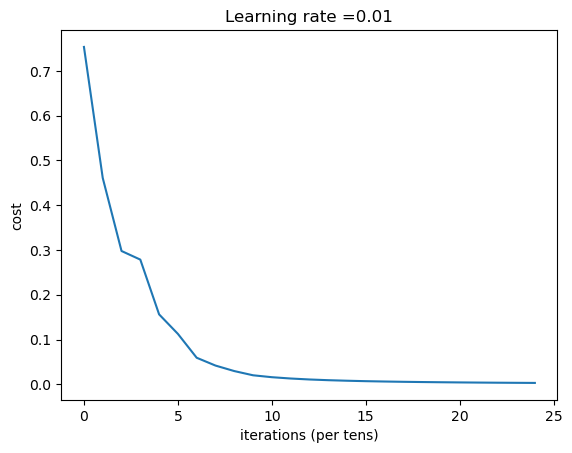

In [46]:
layers_dims = [12288, 64, 32, 1]
lr = 0.01


parameters, costs = L_layer_NN(
            train_x, train_y,
            layers_dims=layers_dims,
            learning_rate=lr,
            num_iterations=2500,
            print_cost=True
        )

In [48]:
def predict_Llayer(test_x, test_y, parameters):

    m = test_y.shape[1]
    
    # Forward propagation
    AL, caches = L_model_forward(test_x, parameters)
    
    y_pred = (AL > 0.5).astype(int)
    
    accuracy = (np.dot(test_y[0],y_pred[0]) + np.dot(1-test_y[0],1-y_pred[0]))/m
    print("Accuracy: ", accuracy)
    
    return accuracy

predictions_test = predict_Llayer(test_x, test_y, parameters)

Accuracy:  0.7
